## MNIST Classification with VGG19 and Batch Normalization


### Import Necessary Libraries
Import PyTorch and other required libraries for loading the data, transforming it, defining the model, and training.

In [21]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time


### Download and Prepare the MNIST Dataset
Download the MNIST dataset using torchvision and create data loaders for training and validation sets.

In [22]:

# Step 1: Download and prepare the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),  # Convert to three-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)  # Normalize for three channels
])


train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


### Define the VGG19 Model with Batch Normalization
Modify the VGG19 model to fit the MNIST dataset by adjusting the final classifier layer.

In [23]:

# Step 2: Define the VGG19 model with batch normalization
class VGG19BN(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19BN, self).__init__()
        # Load a pre-trained VGG19 model with batch normalization
        self.model = models.vgg19_bn(pretrained=False)
        # Replace the classifier to match the number of MNIST classes
        self.model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

    def forward(self, x):
        return self.model(x)


### Initialize Model, Loss Function, and Optimizer
Create an instance of the VGG19 model, define the loss function, and select the optimizer.

In [24]:

# Step 3: Initialize the model, loss function, and optimizer
model = VGG19BN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Check for GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Move the model to the chosen device
model.to(device)

# You can also check the device of a model parameter
print(next(model.parameters()).device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using device: cuda
cuda:0


### Train the Model
Train the model on the training dataset and validate on the validation dataset for the specified number of epochs.

In [25]:
# Step 4: Train the model
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time for the epoch

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    epoch_end_time = time.time()  # End time for the epoch
    epoch_duration = epoch_end_time - epoch_start_time

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, Duration: {epoch_duration:.2f} seconds')


Epoch 1/30, Train Loss: 2.1890, Train Acc: 0.2647, Val Loss: 1.3456, Val Acc: 0.4428, Duration: 108.97 seconds
Epoch 2/30, Train Loss: 1.4002, Train Acc: 0.4846, Val Loss: 0.4418, Val Acc: 0.8934, Duration: 108.77 seconds
Epoch 3/30, Train Loss: 0.6407, Train Acc: 0.8276, Val Loss: 0.3057, Val Acc: 0.9134, Duration: 108.79 seconds
Epoch 4/30, Train Loss: 0.9287, Train Acc: 0.7270, Val Loss: 0.4717, Val Acc: 0.8585, Duration: 108.96 seconds
Epoch 5/30, Train Loss: 0.6627, Train Acc: 0.8199, Val Loss: 0.3374, Val Acc: 0.8908, Duration: 109.28 seconds
Epoch 6/30, Train Loss: 1.2337, Train Acc: 0.7643, Val Loss: 1.5973, Val Acc: 0.3656, Duration: 108.86 seconds
Epoch 7/30, Train Loss: 1.0097, Train Acc: 0.6348, Val Loss: 0.5895, Val Acc: 0.7974, Duration: 108.87 seconds
Epoch 8/30, Train Loss: 0.4535, Train Acc: 0.8705, Val Loss: 0.2694, Val Acc: 0.9285, Duration: 108.33 seconds
Epoch 9/30, Train Loss: 0.2893, Train Acc: 0.9248, Val Loss: 0.1465, Val Acc: 0.9610, Duration: 108.73 seconds
E

### Save Model Weights and Training/Validation Metrics
Save the trained model weights and plot the training/validation loss and accuracy.

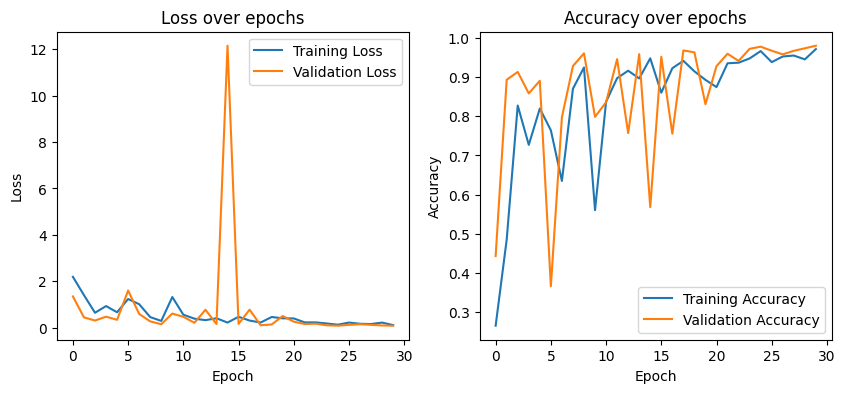

In [26]:

# Step 5: Save the trained model weights
torch.save(model.state_dict(), 'vgg19_bn_mnist.pth')

# Step 6: Record and save the training/validation loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('training_validation_loss_accuracy.png')

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
